## OBIA Practical Exam

Submitted by : Kshitij Raj Sharma

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, segmentation, color, morphology
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import requests
import os
from urllib.parse import urlparse
from skimage.segmentation import mark_boundaries
from skimage.measure import regionprops

## Download image
Download and prepare image to use

In [56]:
def download_image(image_url='https://github.com/kshitijrajsharma/obia-exercise/raw/refs/heads/main/data/Artifical_landscape_UTM_012025.tif', folder="."):
    try:
        response = requests.get(image_url, stream=True)
        response.raise_for_status()
        parsed_url = urlparse(image_url)
        filename = os.path.basename(parsed_url.path)
        filepath = os.path.join(folder, filename)
        with open(filepath, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        return filepath
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image: {e}")
        return None

## Segmentation
Normal segmentation with 3000 segments and 0.3 compactness

In [57]:
def load_and_segment(image_path, n_segments=3000, compactness=0.3):
    image = io.imread(image_path)
    segments = segmentation.slic(image, n_segments=n_segments, compactness=compactness, start_label=1,convert2lab=False)
    return image, segments

In [58]:
def extract_features(image, segments):
    segment_ids = np.unique(segments)
    features = []
    for seg_id in segment_ids:
        mask = segments == seg_id
        mean_color = np.mean(image[mask], axis=0)
        area = np.sum(mask)
        features.append([*mean_color, area])
    return np.array(features), segment_ids

In [17]:
image_path = download_image()
image, segments = load_and_segment(image_path,n_segments=2500, compactness=0.4)
features, segment_ids = extract_features(image, segments)

### Visualize segmented results

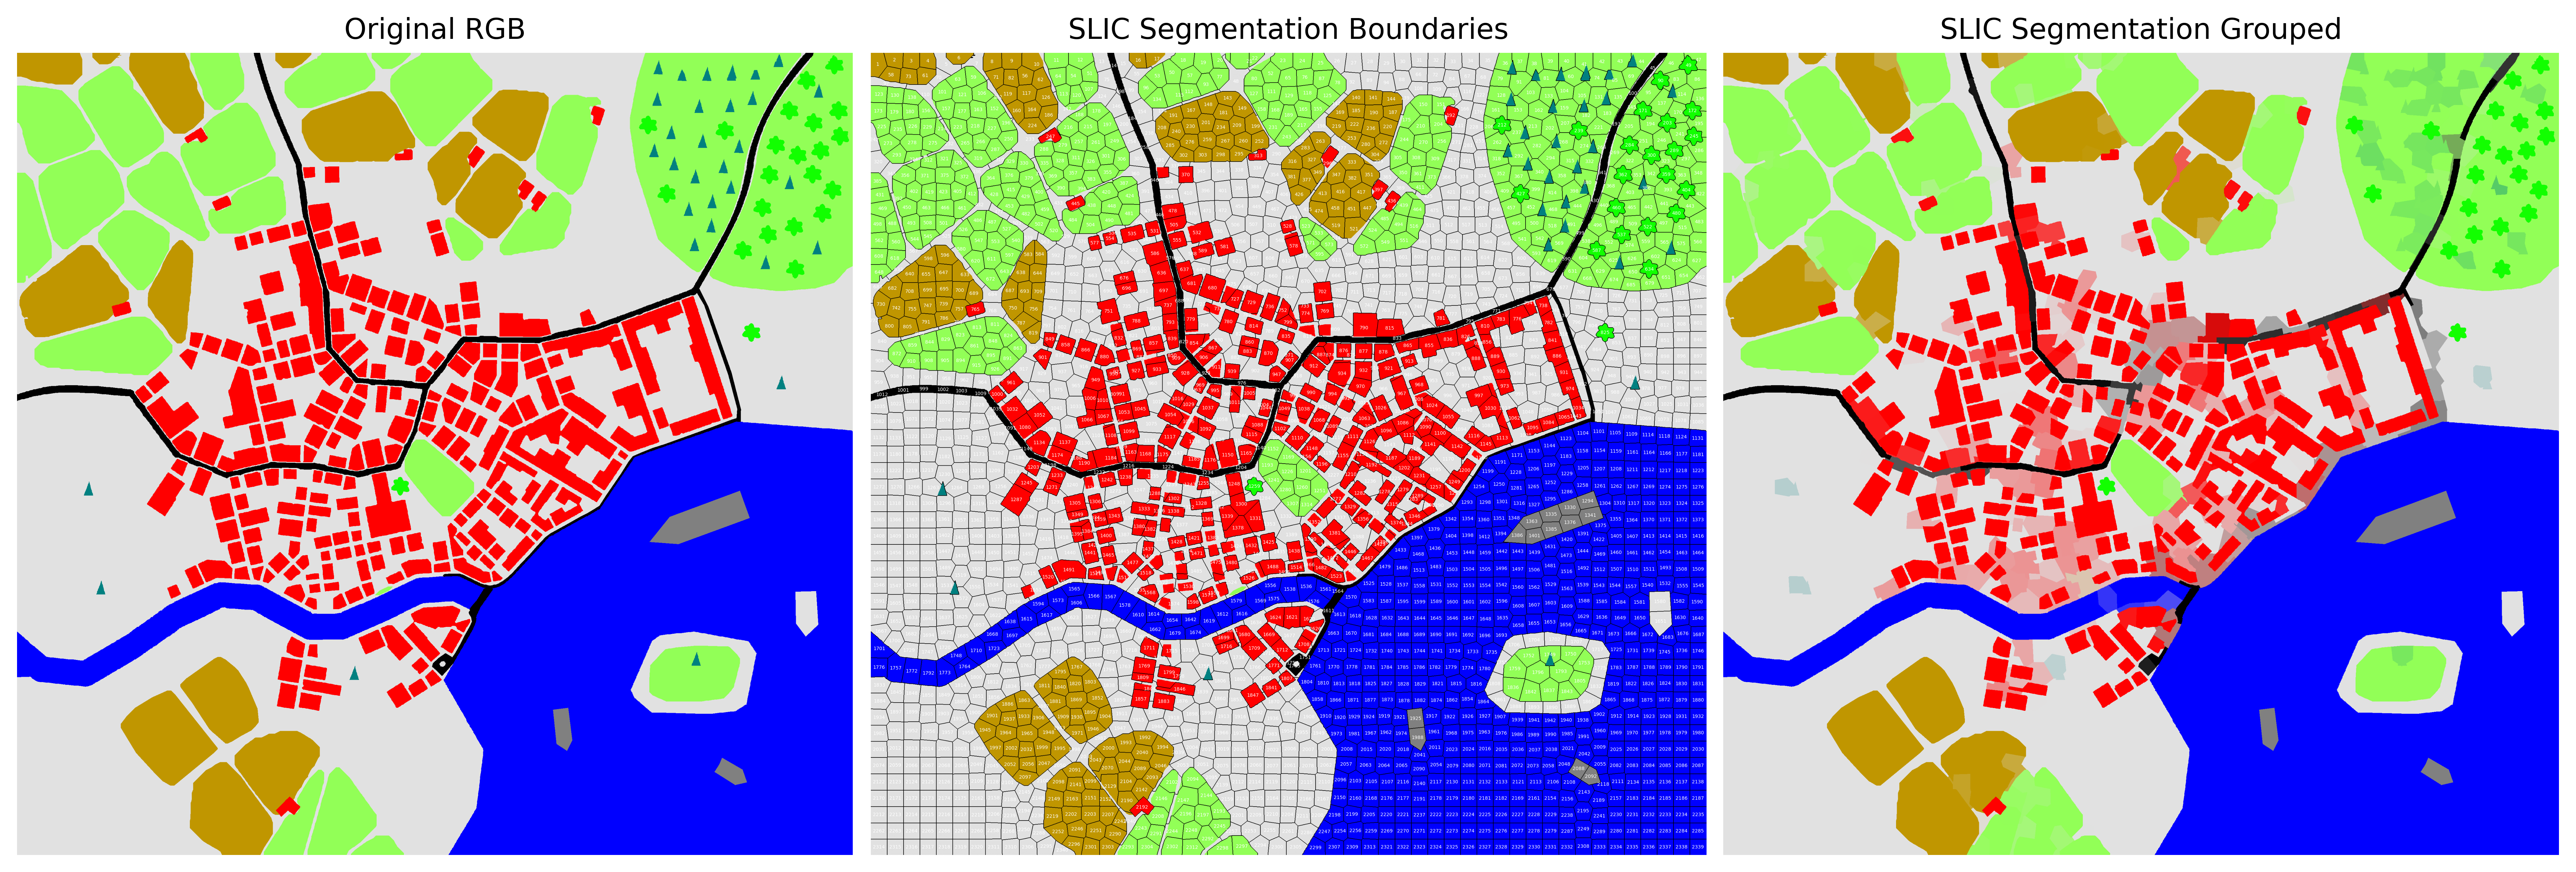

In [63]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5), constrained_layout=True, dpi=500)
axs[0].imshow(image)
axs[0].set_title("Original RGB")
axs[1].imshow(mark_boundaries(image, segments, color=(0, 0, 0), mode="thick"))
axs[1].set_title("SLIC Segmentation Boundaries")
for region in regionprops(segments):
    y0, x0 = region.centroid
    axs[1].text(x0, y0, str(region.label), color="white", fontsize=2, ha='center', va='center')
segmented_avg = color.label2rgb(segments, image, kind='avg')
axs[2].imshow(segmented_avg)
axs[2].set_title("SLIC Segmentation Grouped")
for ax in axs:
    ax.axis('off')
plt.show()


### Training for the classifier

with categories water , road , buildings see the labels in the image and then put it here to classify them automatically using ML algorithms


> Add blockquote



In [146]:
def get_training_samples(segment_ids):
    train_samples = {
        'water':              [1810, 1813, 1818, 1468, 1513,1558],
        'road':               [833, 795, 771, 1232, 1224, 1204],
        'buildings':          [947, 870, 835, 1110 , 970, 932 ],
        'vegetated_land':     [1226, 1201, 1260, 1314, 1251,1169, 2102,2094,2147],
        'non_vegetated_land': [1580, 2088, 1309, 1120, 1182, 1332, 2000, 2044,2040],
        'tree':               [362, 300, 359, 404]
    }
    train_idx = []
    train_labels = []
    for label, seg_ids in train_samples.items():
        for seg in seg_ids:
            if seg in segment_ids:
                idx = np.where(segment_ids == seg)[0][0]
                train_idx.append(idx)
                train_labels.append(label)
    return np.array(train_idx), np.array(train_labels)


In [89]:
train_idx, train_labels = get_training_samples(segment_ids)

In [98]:
def train_classifier(features, train_idx, train_labels, classifier_type='rf'):
    X_train = features[train_idx]
    if classifier_type == 'svm':
        clf = SVC(probability=True)
    elif classifier_type == 'rf':
        clf = RandomForestClassifier()
    clf.fit(X_train, train_labels)
    return clf

## Run random forest

In [99]:
classifier = train_classifier(features, train_idx, train_labels)

In [100]:
def predict_segments(features, classifier):
    return classifier.predict(features)

In [101]:
predictions = predict_segments(features, classifier)

In [102]:
def create_classification_map(segments, segment_ids, predictions):
    class_map = np.empty(segments.shape, dtype=object)
    for seg_val, pred in zip(segment_ids, predictions):
        class_map[segments == seg_val] = pred
    return class_map

In [103]:
class_map = create_classification_map(segments, segment_ids, predictions)

In [104]:
def visualize_classification_map(class_map, colors_dict):
    vis_map = np.zeros(class_map.shape + (3,), dtype=np.uint8)
    unique_labels = np.unique(class_map)
    for label in unique_labels:
        mask = class_map == label
        vis_map[mask] = colors_dict.get(label, (255, 255, 255))
    return vis_map

## Visualize Predictions

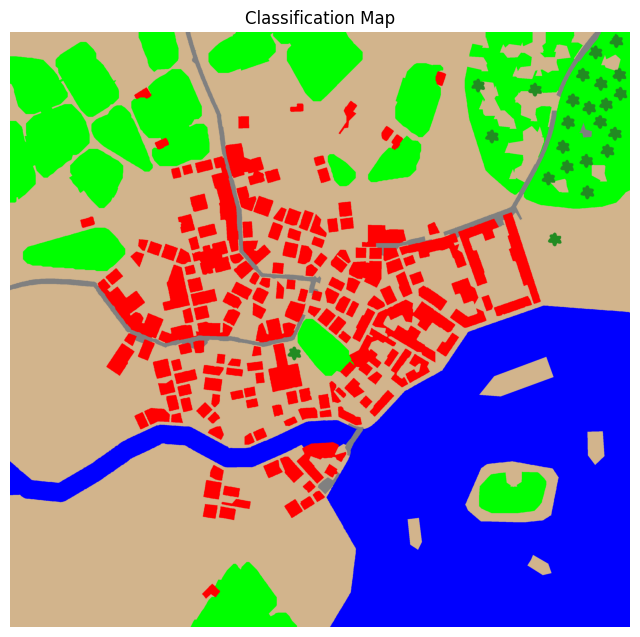

In [105]:
colors = {
    'water': (0, 0, 255),              # Blue
    'road': (128, 128, 128),           # Gray
    'buildings': (255, 0, 0),          # Red
    'vegetated_land': (0, 255, 0),     # Bright green
    'non_vegetated_land': (210, 180, 140), # Tan
    'tree': (34, 139, 34),             # Dark green
}


vis_map = visualize_classification_map(class_map, colors)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(vis_map)
ax.set_title("Classification Map")
ax.axis('off')
plt.show()

### Rule based classification

lets find the grass on top of the island using context based awareness

In [130]:
from skimage import data, segmentation, color
from skimage import graph
import numpy as np
import matplotlib.pyplot as plt


def _weight_mean_color(graph, src, dst, n):

    diff = graph.nodes[dst]['mean color'] - graph.nodes[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}


def merge_mean_color(graph, src, dst):

    graph.nodes[dst]['total color'] += graph.nodes[src]['total color']
    graph.nodes[dst]['pixel count'] += graph.nodes[src]['pixel count']
    graph.nodes[dst]['mean color'] = (
        graph.nodes[dst]['total color'] / graph.nodes[dst]['pixel count']
    )


In [140]:
from skimage import graph

def merge_similar_segments(image, segments, thresh=30):
    rag = graph.rag_mean_color(image, segments, mode='similarity')
    merged_segments = graph.merge_hierarchical(
        segments, rag, thresh=thresh, rag_copy=False, in_place_merge=True,
            merge_func=merge_mean_color,
    weight_func=_weight_mean_color,
    )
    return merged_segments

def get_neighbors(segments, label):
    mask = segments == label
    dilated = morphology.dilation(mask, morphology.square(3))
    boundary_mask = dilated & ~mask
    neighbor_labels = np.unique(segments[boundary_mask])
    neighbor_labels = neighbor_labels[neighbor_labels != label]
    return neighbor_labels

def apply_neighbor_rule_non_veg(class_map, segments,
                                water_label='water', non_veg_label='non_vegetated_land',
                                target_label='island_vegetation', threshold=1.0):
    new_map = class_map.copy()
    unique_labels = np.unique(segments)
    for seg_label in unique_labels:
        seg_class = class_map[segments == seg_label][0]
        if seg_class != non_veg_label:
            continue
        neighbors = get_neighbors(segments, seg_label)
        if len(neighbors) == 0:
            continue
        water_neighbors = 0
        for n in neighbors:
            n_class = class_map[segments == n][0]
            if n_class == water_label:
                water_neighbors += 1
        ratio = water_neighbors / len(neighbors)
        if ratio >= threshold:
            new_map[segments == seg_label] = target_label
    return new_map

In [141]:
merged_segments = merge_similar_segments(image, segments, thresh=30)


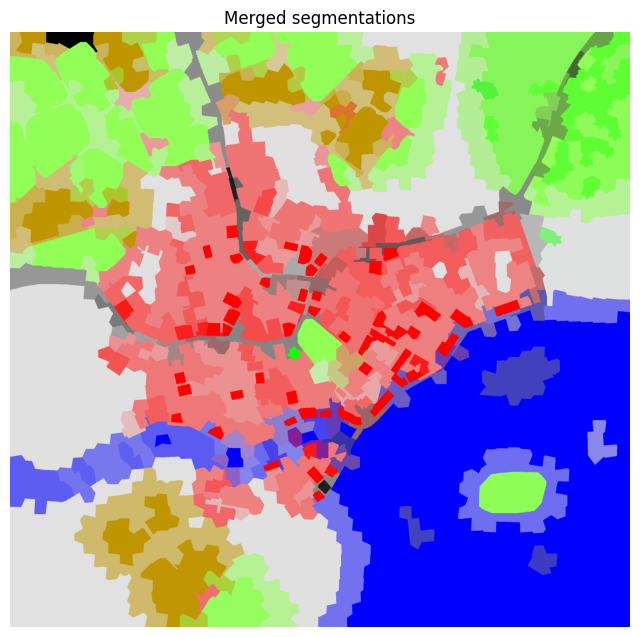

In [142]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(color.label2rgb(merged_segments, image, kind='avg'))
ax.set_title("Merged segmentations")
ax.axis('off')
plt.show()

In [143]:
rule_based_map = apply_neighbor_rule_non_veg(class_map, merged_segments)

<ipython-input-140-81cc4c6382a6>:14: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  dilated = morphology.dilation(mask, morphology.square(3))


In [144]:
colors = {
    'water': (0, 0, 255),
    'road': (128, 128, 128),
    'buildings': (255, 0, 0),
    'vegetated_land': (0, 255, 0),
    'non_vegetated_land': (210, 180, 140),
    'tree': (34, 139, 34),
    'island_vegetation': (255, 255, 0), # Yellow
}

vis_map = visualize_classification_map(rule_based_map, colors)

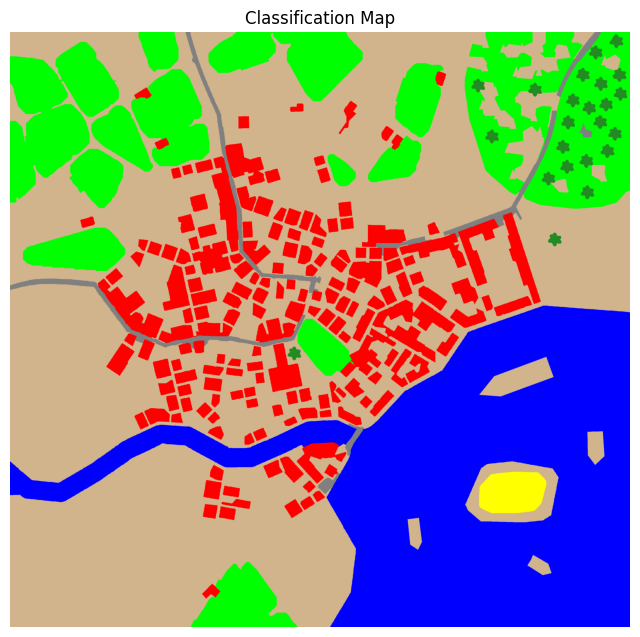

In [145]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(vis_map)
ax.set_title("Classification Map")
ax.axis('off')
plt.show()